In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
import sys
sys.path.append('./Modules')
import monostatic_reconstruct as mr

mm = 1E-3
C = scipy.constants.c

### Load data & antenna coordinates

In [2]:
d_antennas = .035        # distance between tx/rx antennas

mat = scipy.io.loadmat(r'..\..\Data\wall1_with_drywall_2022-11-13.mat')
notes = list(mat['notes'])
print('NOTES:')
for i in range(len(notes)):
        print(notes[i])
f = mat['f'][0,:]
Xa = np.flip(mat['X']*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y']*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Za = np.zeros_like(Xa)
measurements = np.flip(mat['measurements'], axis=(0,1))
z_offset = mat['z_offset'][0,0]*mm

### load background
mat = scipy.io.loadmat(r'..\..\Data\background_2022-11-11.mat')
bg = np.flip(mat['measurements'], axis=(0,1))

### subtract background from measurements
measurements = measurements - bg

NOTES:
second scan of wall1 with drywall.


### Remove probe phase

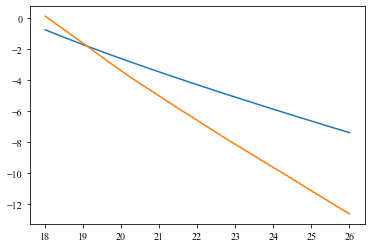

In [3]:
#### load experimentally measured horn phase
mat = scipy.io.loadmat('../../Data/Horn_Calibration_221109/horn_phase.mat')
f_exp = mat['f'][0,:]
phase_error_exp = mat['horn_phase'][0,:]

lam = C/f
k = 2*np.pi/lam

L_horn = .0298
a_horn = 10.668*mm      # WR42
b_horn = 4.318*mm
beta_g = np.sqrt(k**2 - (np.pi/a_horn)**2)
phase_error = np.exp(-1j*2*beta_g*L_horn)    # 2 for transmit and receive path

# measurements = measurements / phase_error[None,None,:]                    # numerically focused horn data
measurements = measurements / np.exp(1j*2*phase_error_exp)[None,None,:]     # experimental horn data

plt.figure()
plt.plot(f*1E-9, np.unwrap(np.angle(phase_error))/2)
plt.plot(f*1E-9, phase_error_exp)
plt.show()

### Reconstruct

In [4]:
recon = mr.MonostaticReconstruction(f, Xa, Ya, z_offset)
# recon.setup((1, 1, .3), (5*mm, 5*mm, 5*mm), Lxa=0.8, Lya=0.8, fc=22E9, bw=8E9, delta_f_indx=4, scene_offsets=(-0.1,-0.2,z_offset), method='RMA-NUFFT')
recon.setup((1, 1, .01), (5*mm, 5*mm, 5*mm), Lxa=0.8, Lya=0.8, fc=24.125E9, bw=0.25E9, delta_f_indx=1, scene_offsets=(-0.1,-0.2,z_offset+0.02), method='RMA-NUFFT', lp_filter=True, filter_radius=40, filter_x_offset=0, filter_y_offset=-55, quiet=False)

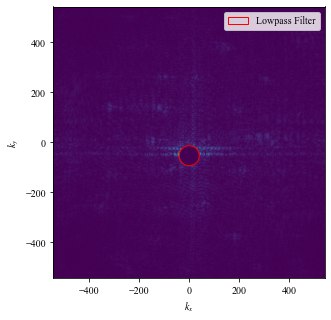

In [5]:
recon.reconstruct(measurements)

### Plot

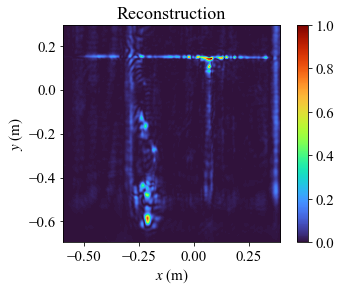

In [6]:
# recon.resample(.5)
recon.plot(plot_type='xy', scale='linear', cmap='turbo', colormin=0, colormax=1)
# recon.plot(plot_type='section', slice_axis='z', scale='linear', cmap='turbo', colormin=0, colormax=.5)
# recon.plot(plot_type='3D', scale='linear', cmap='Turbo', colormin=0, colormax=1, surface_count=100, opacity=0.05)

### Save data

In [9]:
scipy.io.savemat(r'C:\Users\User\Documents\Metacept\Projects\TWI\Experiment\Monostatic Experiments - Shared\Data\Image_Data\wall1_drywall_stage_angled.mat',
                 {'X': recon.volume.X,
                  'Y': recon.volume.Y,
                  'Z': recon.volume.Z,
                  'image': recon.image})